# Facial Expression Recognition: Models

In [1]:
# import libraries
import numpy as np
import pandas as pd
import os
import shutil
import cv2
import dlib
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Dropout, Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.utils import Sequence
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

## Model helper functions

### CNN model

In [2]:
# Creates an convolutional neural network model
def cnn_model(input_shape, num_classes, learning_rate):
    model = Sequential()
    
    # First convolutional block
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.45))  # Early dropout (45%)

    # Second convolutional block
    model.add(Conv2D(128, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.45))

    # Third convolutional block
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.55))  # Increased dropout (55%)

    # Fourth convolutional block
    model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.55))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.65))  # Further increased dropout (65%)

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

### Data augmentations

In [3]:
# Creates image data generators for training, validation, and testing dataset
def image_generator(train_dir, test_dir, target_size, batch_size, color_mode, validation_split):
    # Define train data generator
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=validation_split
    )
    # Define test data generator
    test_datagen = ImageDataGenerator(
        rescale=1./255 
    )
    
    # Create train data generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        subset="training",
        color_mode=color_mode
    )
    
    # Create validation data generators
    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        subset="validation",
        color_mode=color_mode
    )
    
    # Create test data generators
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        color_mode=color_mode
    )
    
    return train_generator, val_generator, test_generator

### Callbacks

In [4]:
# Define callbacks for model training based on input arguments
def create_callbacks(es_monitor, es_patience, lr_monitor, lr_factor, lr_patience, lr_min, cp_monitor, cp_path):
    # Early Stopping
    early_stop = EarlyStopping(
        monitor=es_monitor,
        patience=es_patience,
        restore_best_weights=True,
        mode='max',
        verbose=1
    )
    
    # Learning rate reduction
    lr_reduction = ReduceLROnPlateau(
        monitor=lr_monitor,
        factor=lr_factor,
        patience=lr_patience,
        verbose=1,
        min_lr=lr_min
    )
    
    # Save best model observed
    model_checkpoint = ModelCheckpoint(
        cp_path,
        monitor=cp_monitor,
        verbose=1,
        mode='max',
        save_best_only=True
    )
    
    # Return list of the callbacks
    return [early_stop, lr_reduction, model_checkpoint]

## Evaluation helper functions

In [5]:
# Computes classification metrics and valuates the model on the unseen test dataset. 
# True labels and predicted classes are returned for further analysis
def evaluate_metrics(model, test_generator, combined):
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
    
    # Retrieve predicted classes
    y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Retrieve true labels based image generator type
    if combined == True: # Custom combined image generator
        y_true = test_generator.get_classes_for_steps(len(test_generator))
    else: # Standard image generator
        y_true = test_generator.classes
    
    # Calculate metrics
    precision = precision_score(y_true, y_pred_classes, average='weighted')  # Precision
    recall = recall_score(y_true, y_pred_classes, average='weighted')        # Recall
    f1 = f1_score(y_true, y_pred_classes, average='weighted')                # F1 score
    
    # Store metrics in a dictionary
    metrics = {
        "loss": test_loss,
        "accuracy": test_accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }
    
    # Print results
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Return metrics, true labels, and predicted classes
    return metrics, y_true, y_pred_classes

In [6]:
# Plots accuracy and loss plots
def evaluate_plots(history):
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    fig.set_size_inches(12,4)

    # Accuracy plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Training Accuracy vs Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper left')

    # Loss plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Training Loss vs Validation Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

In [45]:
# Plots the confusion matrix 
def evaluate_cf_matrix(y_true, y_pred_classes):

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    
    # Plot the confusion matrix
    # String value labels are retrived from FER-2013 test generator
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d',
                xticklabels=test_generator_fer.class_indices.keys(),
                yticklabels=test_generator_fer.class_indices.keys())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Model 1: FER-2013

### Data Preprocessing

##### The datasets include many images with facial parts partly or fully covered. Given the applications purpose, only providing certain emotional states are crucial. Therefore, we use landmarks to filter out images where the entire face is not visible. Helping the real-time video detection exclusively provide certain results.

#### Import Dataset

In [8]:
# FER-2013 database directories containing images
# Reference: https://www.kaggle.com/datasets/msambare/fer2013
fer_train = "FER-2013/train" # JPG images for training and validation
fer_test = "FER-2013/test" # JPG images for testing on unseen data

#### Crop and filter images using Haar Cascade

In [9]:
# Create new directories for the cropped and filtered images
fer_train_crop = "FER-2013/train_crop" # New directory path for cropped training images
fer_test_crop = "FER-2013/test_crop"  # New directory path for cropped training images

# Create directories (if they do not already exist)
for subdir in os.listdir(fer_train):
    os.makedirs(os.path.join(fer_train_crop, subdir), exist_ok=True) # Creates cropped training directory
    os.makedirs(os.path.join(fer_test_crop, subdir), exist_ok=True)  # Creates cropped testing directory

In [10]:
# Load Haar cascade classifier
# Reference: https://github.com/opencv/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [11]:
# Detects faces using Haar cascade classifier, saves 3 versions of each face: the original, a tight, and a moderate face crop.
# The input blur value further filters images that are/become to blurred. 
def face_crop_filter(src_dir, dest_dir, max_blur):
    # Iterate over the source directory
    for emotion in os.listdir(src_dir):
        src_emotion = os.path.join(src_dir, emotion)    # Emotion folder in source directory
        dest_emotion = os.path.join(dest_dir, emotion)  # Emotion folder in source directory

        # Iterate images in emotions directory
        for filename in os.listdir(src_emotion):
            # Check if the emotion directory contains filtered images already
            if any(filename.lower().endswith(('.png', '.jpg', '.jpeg')) for filename in os.listdir(dest_emotion)):
                print(f"Found images in {dest_emotion}. Exiting function.")
            return  # Exit if images are found
            
            img_path = os.path.join(src_emotion, filename)
            image = cv2.imread(img_path)

            # Error handling: Potential non-image file formats or OpenCV image read errors 
            if image is None:
                print(f"Skipping invalid image: {filename}")
                continue
            
            # Detect face for current image using Haar cascade classifier
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert to greyscale
            face = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            # Calculate variance of the Laplacian: Blur detection
            laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()

            # Process images non-blurred images where a face is detected.
            if len(face) > 0 and laplacian_var > max_blur:
                for i, (x, y, w, h) in enumerate(face):
                    # Calculate the center of the face
                    face_center_x = x + w // 2
                    face_center_y = y + h // 2

                    # Tight crop around the centered face
                    tight_crop_x1 = max(0, face_center_x - int(0.90 * w) // 2)
                    tight_crop_y1 = max(0, face_center_y - int(0.90 * h) // 2)
                    tight_crop_x2 = min(image.shape[1], face_center_x + int(0.90 * w) // 2)
                    tight_crop_y2 = min(image.shape[0], face_center_y + int(0.90 * h) // 2)
                    tight_crop = image[tight_crop_y1:tight_crop_y2, tight_crop_x1:tight_crop_x2]
                    
                    # Moderate crop around the centered face
                    moderate_crop_x1 = max(0, face_center_x - int(1.1 * w) // 2)
                    moderate_crop_y1 = max(0, face_center_y - int(1.1 * h) // 2)
                    moderate_crop_x2 = min(image.shape[1], face_center_x + int(1.1 * w) // 2)
                    moderate_crop_y2 = min(image.shape[0], face_center_y + int(1.1 * h) // 2)
                    moderate_crop = image[moderate_crop_y1:moderate_crop_y2, moderate_crop_x1:moderate_crop_x2]
                    
                    # Save original image
                    original_filename = f"{os.path.splitext(filename)[0]}_original.jpg" # Add suffix to file name
                    original_img_path = os.path.join(dest_emotion, original_filename) # Path
                    cv2.imwrite(original_img_path, image)
                    
                    # Save the tight crop 
                    tight_crop_filename = f"{os.path.splitext(filename)[0]}_tight_crop.jpg" # Add suffix to file name
                    tight_crop_path = os.path.join(dest_emotion, tight_crop_filename) # Path
                    cv2.imwrite(tight_crop_path, cv2.resize(tight_crop, (48, 48))) # Save in target size
                               
                    # Save the moderate crop 
                    moderate_crop_filename = f"{os.path.splitext(filename)[0]}_moderate_crop.jpg" # Add suffix to file name
                    moderate_crop_path = os.path.join(dest_emotion, moderate_crop_filename) # Path
                    cv2.imwrite(moderate_crop_path, cv2.resize(moderate_crop, (48, 48))) # Save in target size

In [12]:
# Crop and filter training data
face_crop_filter(fer_train, fer_train_crop, 10)

# Crop and filter test data
face_crop_filter(fer_test, fer_test_crop, 10)

Found images in FER-2013/train_crop\angry. Exiting function.
Found images in FER-2013/test_crop\angry. Exiting function.


### Data Augmentation

In [13]:
# Create image data generator for FER-2013
train_generator_fer, val_generator_fer, test_generator_fer = image_generator(
    fer_train_crop, # Cropped and filtered train directory
    fer_test_crop,  # Croped and filtered test directory
    (48,48),        # Target image size
    32,             # Batch size
    'grayscale',    # Color mode
    0.2             # Training/validation split
)

Found 16032 images belonging to 7 classes.
Found 4005 images belonging to 7 classes.
Found 5004 images belonging to 7 classes.


### Build and train model

In [14]:
# Build CNN model for FER-2013
model_fer = cnn_model(
    (48, 48, 1),                 # Input shape
    7,                           # No. of classes
    0.0001                       # Learning rate
)

# Define callbacks
calbacks_fer = create_callbacks(
    'val_accuracy',              # Early stop monitor
    35,                          # Early stop patience
    'val_loss',                  # Learning reduction monitor
    0.5,                         # Learning reduction factor
    4,                           # Learning reduction patience
    1e-6,                        # Learning reduction min
    'val_accuracy',              # Checkpoint monitor
    'expression_model_FER.h5'    # Checkpoint path
)

# Train the model with early stopping
history_fer = model_fer.fit(
    train_generator_fer,                  # Train generator
    epochs = 250,                         # No. of epochs
    validation_data = val_generator_fer,  # Validation generator
    callbacks = calbacks_fer              # Callbacks
)

Epoch 1/250
498/501 [============================>.] - ETA: 0s - loss: 8.1501 - accuracy: 0.1963
Epoch 1: val_accuracy improved from -inf to 0.31860, saving model to expression_model_FER.h5
501/501 [==============================] - 11s 20ms/step - loss: 8.1483 - accuracy: 0.1963 - val_loss: 8.6995 - val_accuracy: 0.3186 - lr: 1.0000e-04
Epoch 2/250
501/501 [==============================] - ETA: 0s - loss: 7.4413 - accuracy: 0.2252
Epoch 2: val_accuracy improved from 0.31860 to 0.31935, saving model to expression_model_FER.h5
501/501 [==============================] - 9s 18ms/step - loss: 7.4413 - accuracy: 0.2252 - val_loss: 9.6289 - val_accuracy: 0.3194 - lr: 1.0000e-04
Epoch 3/250
501/501 [==============================] - ETA: 0s - loss: 6.9215 - accuracy: 0.2506
Epoch 3: val_accuracy improved from 0.31935 to 0.32260, saving model to expression_model_FER.h5
501/501 [==============================] - 10s 19ms/step - loss: 6.9215 - accuracy: 0.2506 - val_loss: 7.8434 - val_accuracy:

## Evaluation

### Calculate metrics

In [15]:
# Compute metrics and evaluate on unseen test data generator
metrics_fer, y_true_fer, y_pred_classes_fer = evaluate_metrics(
    model_fer,           # Model
    test_generator_fer,  # Unseen test data generator
    False                # Combined generator input argument (False = single data generator, True = combined custom data generator)
)

157/157 [==============================] - 2s 13ms/step
Test Accuracy: 0.6922
Test Loss: 1.0910
Precision: 0.6852
Recall: 0.6922
F1 Score: 0.6804


### Accuracy and loss plot

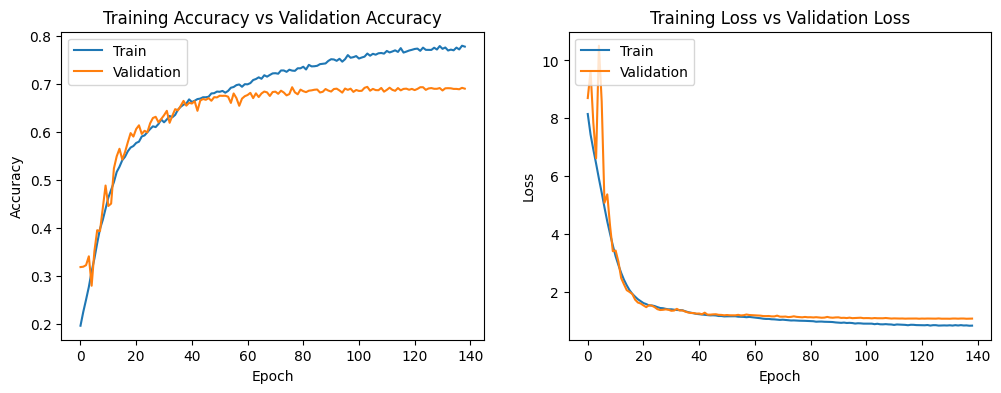

In [16]:
# Plot accuray and loss for FER-2013 dataset
evaluate_plots(history_fer)

### Confusion matrix

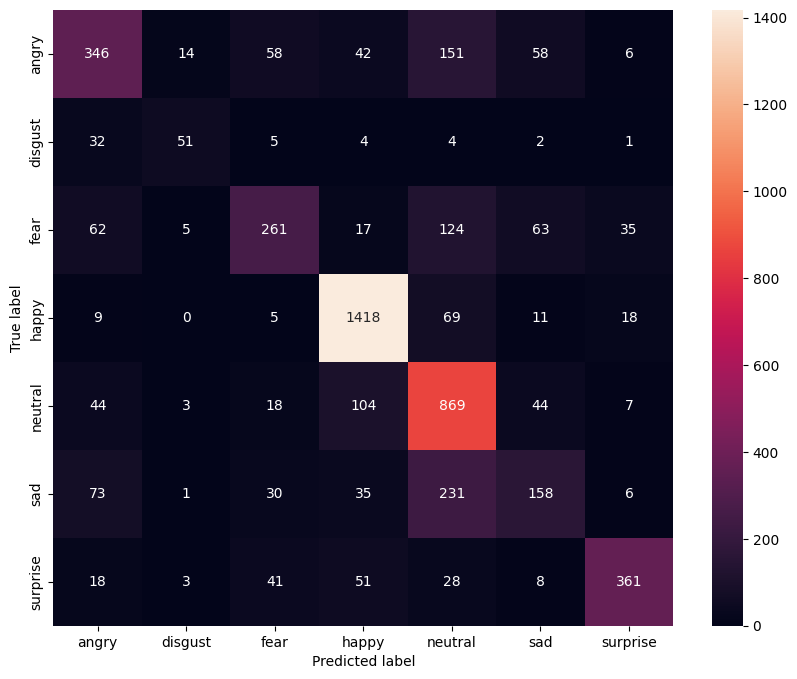

In [48]:
# Plot confusion matrix for FER-2013 dataset
evaluate_cf_matrix(y_true_fer, y_pred_classes_fer)

### Classification report

In [18]:
# Print classification report for FER-2013 dataset
print(classification_report(y_true_fer, y_pred_classes_fer, target_names=test_generator_fer.class_indices.keys()))

              precision    recall  f1-score   support

       angry       0.59      0.51      0.55       675
     disgust       0.66      0.52      0.58        99
        fear       0.62      0.46      0.53       567
       happy       0.85      0.93      0.89      1530
     neutral       0.59      0.80      0.68      1089
         sad       0.46      0.30      0.36       534
    surprise       0.83      0.71      0.76       510

    accuracy                           0.69      5004
   macro avg       0.66      0.60      0.62      5004
weighted avg       0.69      0.69      0.68      5004



## Conclusion

The model trained on the FER-2013 dataset has improved significantly compared to previous iterations. However, the model is still overfitting and several emotion classes are severely misclassified, e.g. sad and angry are often classified as neutral, and the model is unable to correctly predict the emotion 'disgust'.

## Model 2: RAF-DB

Because the model trained on the FER-2013 dataset does not work as intended. We build a model using the RAF-DB dataset instead.

#### Import Dataset

In [ ]:
# Real-world Affective Faces Database (RAF-DB) dataset directories containing images
# Reference: https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset
raf_train = "RAF-DB/DATASET/train" # Images for training and validation
raf_test = "RAF-DB/DATASET/test" # Images for testing on unseen data

### Filter images using dlib's face detector

The intended use of the model requires that we only make an emotion estimate when a face is detected, e.g. predictions with covered facial parts should not be made. Therefore, we use the face detection to filter out images that cannot and should not be predicted by the detection code (emotion_detection.py). Also, since it is highly unlikely that the real-time application will use blurred video, images with high levels of blur are filtered out.

### Filter images based on facial landmarks and image quality

In [20]:
# Create new directories for the cropped and filtered images
raf_train_lm = 'RAF-DB/DATASET/train_lm' # New directory path for landmark and blur filtered training images
raf_test_lm = 'RAF-DB/DATASET/test_lm'  # New directory path for landmark and blur filtered testing images

# Create directories (if they do not already exist)
for subdir in os.listdir(raf_train):
    os.makedirs(os.path.join(raf_train_lm, subdir), exist_ok=True) # Creates filtered training directory
    os.makedirs(os.path.join(raf_test_lm, subdir), exist_ok=True)  # Creates filtered testing directory

In [21]:
# Load dlib's face detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [22]:
# Function that detects faces and return a normalized array with facial landmarks
def get_landmarks(image, img_size):
    # Convert color images to greyscale
    if len(image.shape) == 3 and image.shape[2] == 3: 
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Detect faces in greyscale image using dlib's frontal face detector
    face = detector(gray)

    # Return normalized array oflandmarks for detected faces 
    if len(face) > 0:
        landmarks = predictor(gray, face[0]) # Obtain landmarks using dlib's facial lanmark predictor
        coords = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)] # The 68 face landmark coordinates 
        normalized_landmarks = [(x / img_size[0], y / img_size[1]) for (x, y) in coords] # Normalize landmarks
        return np.array(normalized_landmarks).flatten() # return normalized and flattened landmark array
    else:
        return np.zeros(68 * 2)  # Return array with 0's if no face is detected

In [23]:
# Copies images with valid lanmarks and required quality to the filtered directory
def filter_images(src_dir, dest_dir, max_blur):
     # Iterate over the source directory
    for emotion in os.listdir(src_dir):
        src_emotion = os.path.join(src_dir, emotion) # Emotion folder in source directory
        dest_emotion = os.path.join(dest_dir, emotion)  # Emotion folder in source directory

        # Iterate images in emotions directory
        for filename in os.listdir(src_emotion):
             # Check if the emotion directory contains filtered images already
            if any(filename.lower().endswith(('.png', '.jpg', '.jpeg')) for filename in os.listdir(dest_emotion)):
                print(f"Found images in {dest_emotion}. Exiting function.")
            return  # Exit if images are found
            
            img_path = os.path.join(src_emotion, filename)
            image = cv2.imread(img_path)

            # Error handling: Potential non-image file formats or OpenCV image read errors 
            if image is None:
                print(f"Skipping invalid image: {filename}")
                continue
            
            # Get normalized landmarks for the image
            landmark_array = get_landmarks(image, (100, 100))
            
            # Calculate variance of the Laplacian: Blur detection
            laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()

            # Process non-blurred images where where the normalized landmark array is valid (not all 0's)
            if np.count_nonzero(landmark_array) > 0 and laplacian_var > max_blur:
                # Copy the image to the filtered directory
                dest_img_path = os.path.join(dest_dir, emotion, img_name) # File path
                shutil.copy(img_path, dest_img_path)  # Copy to detination folder

In [24]:
# Copy non-blurred training images with face detected to the filtered training directory
filter_images(raf_train, raf_train_lm, 20)

# Copy non-blurred training images with face detected to the filtered testing directory
filter_images(raf_test, raf_test_lm, 20)

Found images in RAF-DB/DATASET/train_lm\1. Exiting function.
Found images in RAF-DB/DATASET/test_lm\1. Exiting function.


In [25]:
# Plots lanmarks on random images
def plot_landmarks(directory, img_size, num_samples):
    images, landmarks, all_images = [], [], [] # Initalize lists for storing images, landmkarks, and paths of all images

    # Load paths of all images from input directory
    for emotion in os.listdir(directory):
        dir_emotion = os.path.join(directory, emotion)
        # Iterate images in input directory
        for filename in os.listdir(dir_emotion):
            img_path = os.path.join(dir_emotion, filename)
            all_images.append(img_path)  # Add all image paths to list

    # Randomly select images from the list of all images path
    sample = np.random.choice(all_images, num_samples, replace=False)

    # Process sampled images
    for img_path in sample:
        # Read and convert to greyscale
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Extract landmarks
        landmark_array = get_landmarks(image, (100,100))
        # Append to lists
        images.append(image)
        landmarks.append(landmark_array)
        
    # Convert images and landmarks to numpy arrays
    images, landmarks = np.array(images), np.array(landmarks)

    # Plot the randomly selected images
    plt.figure(figsize=(12, 3))
    # Iterate over number of samples and plot side-by-side
    for i in range(num_samples):
        # Copy image and convert reshape landmarks points
        image = images[i].copy()
        points = (landmarks[i].reshape(-1, 2) * img_size).astype(int)
        
        # Draw the landmarks on top of the image
        for x, y in points:
            cv2.circle(image, (x, y), 1, (0, 255, 0), -1)
        
        # Add to subplot
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


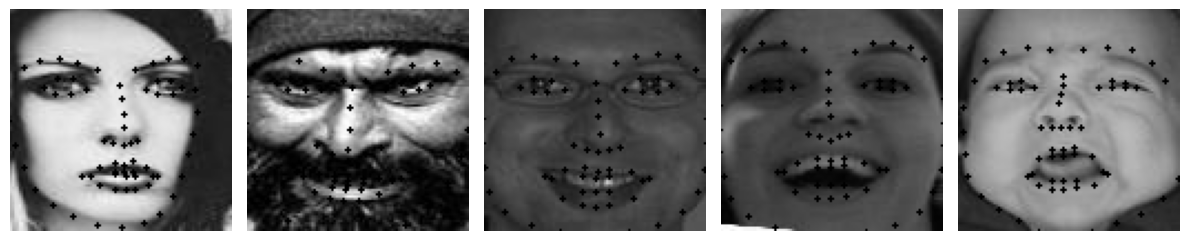

In [26]:
# Plot 5 random images to verify that landmarks are correctly detected
plot_landmarks(raf_train_lm, (100, 100), 5)

### Data Augmentation

In [27]:
# Create image data generator for RAF-DB
train_generator_raf, val_generator_raf, test_generator_raf = image_generator(
    raf_train_lm, # Cropped and filtered train directory
    raf_test_lm,  # Croped and filtered test directory
    (100,100),        # Target image size
    32,             # Batch size
    'grayscale',    # Color mode
    0.125             # Training/validation split
)

Found 8086 images belonging to 7 classes.
Found 1151 images belonging to 7 classes.
Found 2312 images belonging to 7 classes.


### Build & train the model

In [28]:
# Build CNN model for RAF-DB
model_raf = cnn_model(
    (100, 100, 1),               # Input shape
    7,                           # No. of classes
    0.0001                       # Learning rate
)

# Define callbacks
calbacks_raf = create_callbacks(
    'val_accuracy',              # Early stop monitor
    35,                          # Early stop patience
    'val_loss',                  # Learning reduction monitor
    0.5,                         # Learning reduction factor
    4,                           # Learning reduction patience
    1e-6,                        # Learning reduction min
    'val_accuracy',              # Checkpoint monitor
    'expression_model_RAF.h5'    # Checkpoint path
)

# Train the model with early stopping
history_raf = model_raf.fit(
    train_generator_raf,                  # Train generator
    epochs = 250,                         # No. of epochs
    validation_data = val_generator_raf,  # Validation generator
    callbacks = calbacks_raf              # Callbacks
)

Epoch 1/250
252/253 [============================>.] - ETA: 0s - loss: 7.9481 - accuracy: 0.2307
Epoch 1: val_accuracy improved from -inf to 0.42311, saving model to expression_model_FER.h5
253/253 [==============================] - 11s 38ms/step - loss: 7.9477 - accuracy: 0.2305 - val_loss: 9.1537 - val_accuracy: 0.4231 - lr: 1.0000e-04
Epoch 2/250
253/253 [==============================] - ETA: 0s - loss: 7.1734 - accuracy: 0.3353
Epoch 2: val_accuracy did not improve from 0.42311
253/253 [==============================] - 9s 34ms/step - loss: 7.1734 - accuracy: 0.3353 - val_loss: 10.9515 - val_accuracy: 0.2919 - lr: 1.0000e-04
Epoch 3/250
253/253 [==============================] - ETA: 0s - loss: 6.6927 - accuracy: 0.4126
Epoch 3: val_accuracy improved from 0.42311 to 0.44570, saving model to expression_model_FER.h5
253/253 [==============================] - 9s 34ms/step - loss: 6.6927 - accuracy: 0.4126 - val_loss: 12.0863 - val_accuracy: 0.4457 - lr: 1.0000e-04
Epoch 4/250
253/253

### Evaluation

#### Calculate metrics

In [41]:
# Compute metrics and evaluate on unseen test data generator for RAF-DB
metrics_raf, y_true_raf, y_pred_classes_raf = evaluate_metrics(
    model_raf,           # Model
    test_generator_raf,  # Unseen test data generator
    False                # Combined generator input argument (False = single data generator, True = combined custom data generator)
)

73/73 [==============================] - 1s 16ms/step
Test Accuracy: 0.8452
Test Loss: 0.7230
Precision: 0.8428
Recall: 0.8452
F1 Score: 0.8421


#### Accuracy and loss plot

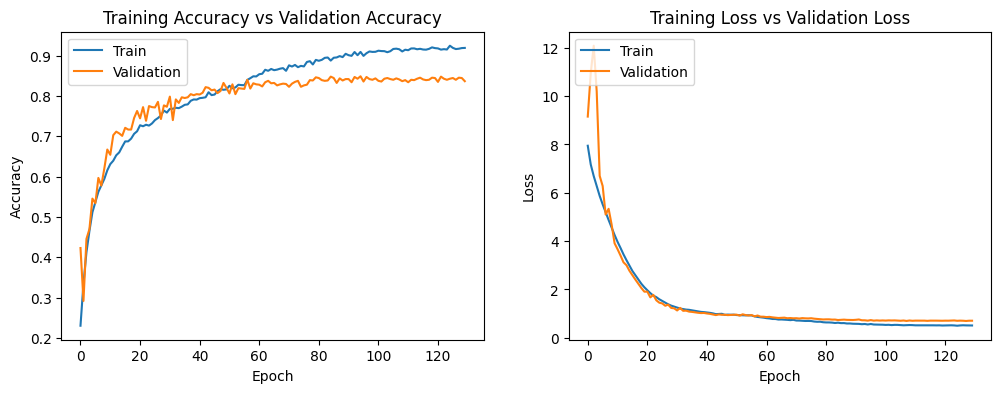

In [30]:
# Plot accuray and loss for RAF-DB dataset
evaluate_plots(history_raf)

#### Confusion matrix

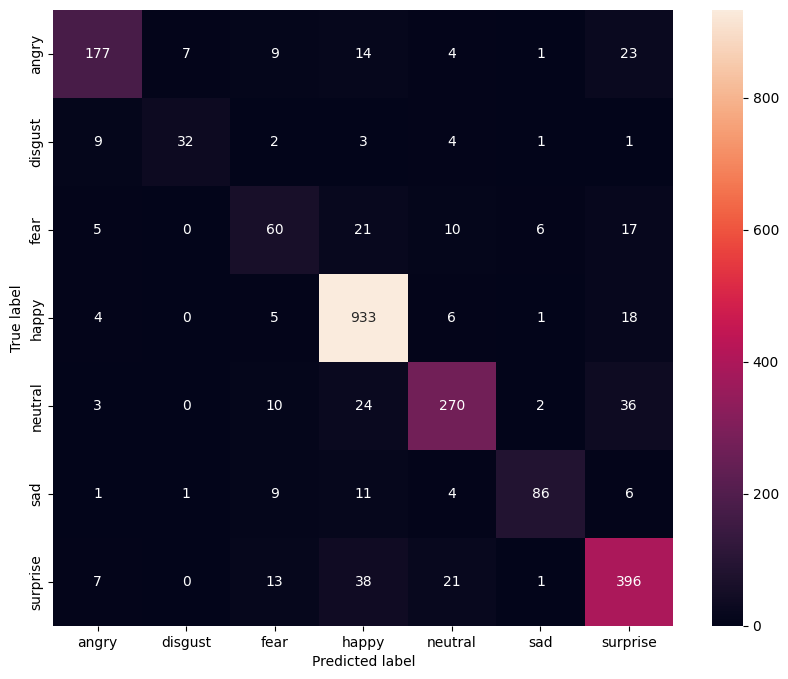

In [46]:
# Plot confusion matrix for RAF-DB dataset
evaluate_cf_matrix(y_true_raf, y_pred_classes_raf)

#### Classification report

In [44]:
# Print classification report for RAF-DB dataset
print(classification_report(y_true_raf, y_pred_classes_raf, target_names=test_generator_fer.class_indices.keys()))

              precision    recall  f1-score   support

       angry       0.86      0.75      0.80       235
     disgust       0.80      0.62      0.70        52
        fear       0.56      0.50      0.53       119
       happy       0.89      0.96      0.93       967
     neutral       0.85      0.78      0.81       345
         sad       0.88      0.73      0.80       118
    surprise       0.80      0.83      0.81       476

    accuracy                           0.85      2312
   macro avg       0.80      0.74      0.77      2312
weighted avg       0.84      0.85      0.84      2312



## Conclusion

The model trained on the RAF-DB dataset performs significantly better than the model using FER-2013. However, the model seems to have a problem classifying the emotion 'fear'. Also, the support for 'disgust' is quite low.

## Model 3: FER2013 and RAF-DB combined

Combining the FER-2013 and RAF-DB datasets could potentially lead to a model that generalises better.

### Data augmentations

In [33]:
# Create resized image data generator for FER-2013
train_generator_fer_res, val_generator_fer_res, test_generator_fer_res = image_generator(
    fer_train_crop, # Cropped and filtered train directory
    fer_test_crop,  # Croped and filtered test directory
    (100,100),      # Resized target image size
    32,             # Batch size
    'grayscale',    # Color mode
    0.2             # Training/validation split
)

Found 16032 images belonging to 7 classes.
Found 4005 images belonging to 7 classes.
Found 5004 images belonging to 7 classes.


In [34]:
# Custom class for combining FER-2013 and RAF-DB image data generator
class CombinedDataGenerator(Sequence):
    # Initialize the combined data generator
    def __init__(self, gen_raf, gen_fer, emotion_map):
        # Define generators and emotion mapping
        self.gen_raf = gen_raf            # FER-2013 generator
        self.gen_fer = gen_fer            # RAF-DB generator
        self.emotion_map = emotion_map    # Emotion label mapping

        # Define classes and class_indices attributes for model evaluation
        self.classes = np.concatenate([self.gen_raf.classes, self.gen_fer.classes])  # Custom classes attribute
        self.class_indices = self.gen_fer.class_indices                              # Custom class indices attribute

    # Length for steps per epoch
    def __len__(self):
        return max(len(self.gen_raf), len(self.gen_fer))
        
    # Retrieve true labels for steps generated (used for model evaluation)
    def get_classes_for_steps(self, steps):
        y_classes = []
        for idx in range(steps):
            _, y_batch = self[idx]
            y_classes.append(y_batch.argmax(axis=-1))
        return np.concatenate(y_classes, axis=0)

    # Retrieve combined data and labels
    def __getitem__(self, idx):
        # Get one batch from each generator
        x_raf, y_raf = self.gen_raf[idx % len(self.gen_raf)]
        x_fer, y_fer = self.gen_fer[idx % len(self.gen_fer)]

        # Map the RAF-DB emotion labels FER-2013 using the emotion_map dictionary
        y_raf_mapped = np.array([self.emotion_map[emotion] for emotion in y_raf.argmax(axis=-1)])  # RAF-DB emotion labels mapped
        y_fer_mapped = np.array([emotion for emotion in y_fer.argmax(axis=-1)])                    # FER-2013 emotion labels

        # Combine data and labels from both generators
        x_combined = np.concatenate([x_raf, x_fer], axis=0)                # Image data
        y_combined = np.concatenate([y_raf_mapped, y_fer_mapped], axis=0)  # Emotion labels

        # One-hot encode emotion labels
        y_combined = np.eye(7)[y_combined] 

        # Return combined data generator
        return x_combined, y_combined

In [35]:
# Create emotion map dictionary from RAF-DB to FER-2013. (Notice: RAF-DB emotion labels are converted to 0-base via flow_from_directory)
emotion_map = {
    # RAF-DB -> FER-2013
    0: 5,  # Surprise(1) -> Surprise (5)
    1: 2,  # Fear(2) -> Fear(2 - fear)
    2: 1,  # Disgust(3) -> Disgust(3)
    3: 3,  # Happiness(4) -> Happy(3)
    4: 4,  # Sadness(5) -> Sad(4)
    5: 0,  # Anger(6) -> Angry(0)
    6: 6   # Neutral(7) -> Neutral(6)
}

#  Create combined data generators
train_generator_comb = CombinedDataGenerator(train_generator_raf, train_generator_fer_res, emotion_map)
val_generator_comb = CombinedDataGenerator(val_generator_raf, val_generator_fer_res, emotion_map)
test_generator_comb = CombinedDataGenerator(test_generator_raf, test_generator_fer_res, emotion_map)

### Build and train model

In [36]:
# Build CNN model for FER-2013 and RAF-DB combined
model_comb = cnn_model(
    (100, 100, 1),               # Input shape
    7,                           # No. of classes
    0.0001                       # Learning rate
)

# Define callbacks
calbacks_comb = create_callbacks(
    'val_accuracy',              # Early stop monitor
    35,                          # Early stop patience
    'val_loss',                  # Learning reduction monitor
    0.5,                         # Learning reduction factor
    4,                           # Learning reduction patience
    1e-6,                        # Learning reduction min
    'val_accuracy',              # Checkpoint monitor
    'expression_model_COMB.h5'    # Checkpoint path
)

# Train the model with early stopping
history_comb = model_comb.fit(
    train_generator_comb,                  # Train generator
    epochs = 250,                          # No. of epochs
    validation_data = val_generator_comb,  # Validation generator
    callbacks = calbacks_comb              # Callbacks
)

Epoch 1/250
501/501 [==============================] - ETA: 0s - loss: 7.7349 - accuracy: 0.2236
Epoch 1: val_accuracy improved from -inf to 0.28155, saving model to expression_model_COMB.h5
501/501 [==============================] - 35s 67ms/step - loss: 7.7349 - accuracy: 0.2236 - val_loss: 8.8610 - val_accuracy: 0.2816 - lr: 1.0000e-04
Epoch 2/250
501/501 [==============================] - ETA: 0s - loss: 6.5676 - accuracy: 0.3307
Epoch 2: val_accuracy improved from 0.28155 to 0.37914, saving model to expression_model_COMB.h5
501/501 [==============================] - 32s 64ms/step - loss: 6.5676 - accuracy: 0.3307 - val_loss: 7.1404 - val_accuracy: 0.3791 - lr: 1.0000e-04
Epoch 3/250
501/501 [==============================] - ETA: 0s - loss: 5.5961 - accuracy: 0.4079
Epoch 3: val_accuracy improved from 0.37914 to 0.40951, saving model to expression_model_COMB.h5
501/501 [==============================] - 32s 64ms/step - loss: 5.5961 - accuracy: 0.4079 - val_loss: 6.6825 - val_accur

### Evaluation

#### Calculate metrics

In [37]:
# Compute metrics and evaluate on unseen test data generator for FER-2013 and RAF-DB combined
metrics_comb, y_true_comb, y_pred_classes_comb = evaluate_metrics(model_comb, test_generator_comb, True)

157/157 [==============================] - 5s 33ms/step
Test Accuracy: 0.7508
Test Loss: 0.8952
Precision: 0.7502
Recall: 0.7508
F1 Score: 0.7409


#### Accuracy and loss plot

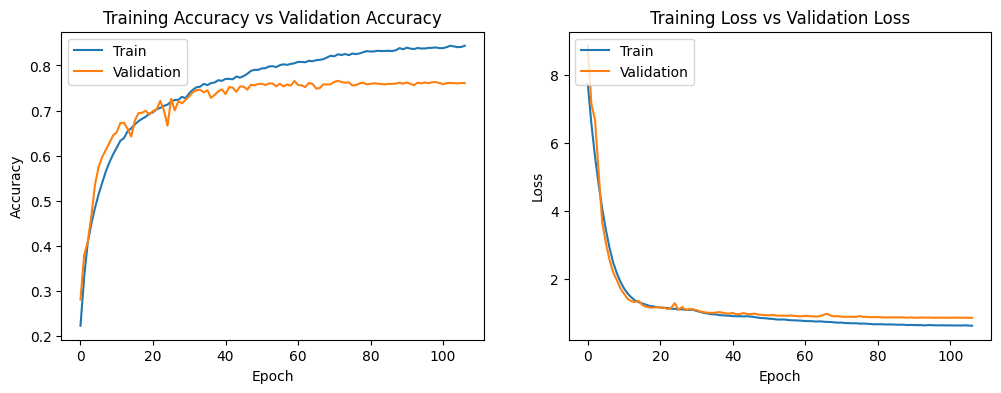

In [38]:
# Plot accuray and loss for FER-2013 and RAF-DB combined
evaluate_plots(history_comb)

#### Confusion matrix

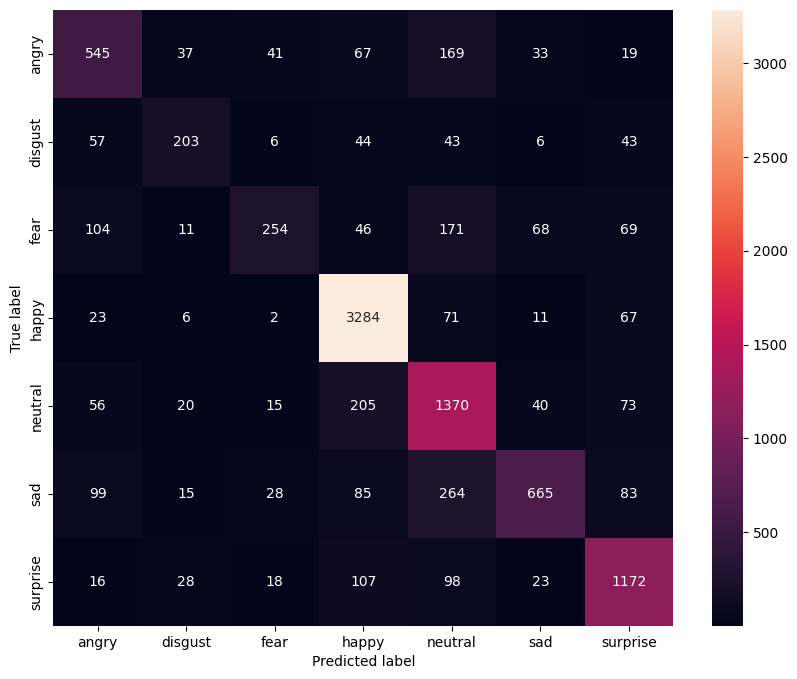

In [47]:
# Plot confusion matrix for FER-2013 and RAF-DB combined
evaluate_cf_matrix(y_true_comb, y_pred_classes_comb)

#### Classification report

In [40]:
# Print classification report for FER-2013 and RAF-DB combined
print(classification_report(y_true_comb, y_pred_classes_comb, target_names=test_generator_comb.class_indices.keys()))

              precision    recall  f1-score   support

       angry       0.61      0.60      0.60       911
     disgust       0.63      0.50      0.56       402
        fear       0.70      0.35      0.47       723
       happy       0.86      0.95      0.90      3464
     neutral       0.63      0.77      0.69      1779
         sad       0.79      0.54      0.64      1239
    surprise       0.77      0.80      0.78      1462

    accuracy                           0.75      9980
   macro avg       0.71      0.64      0.66      9980
weighted avg       0.75      0.75      0.74      9980



## Conclusion

The combined model has increased classification support, but ultimately performs worse than the model trained on the RAF DB dataset.